<a href="https://colab.research.google.com/github/pibieta/ML-course/blob/master/cargox/Thomas_Andrews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Thomas-Andrews case
---
J. P. Ibieta-Jimenez

In [0]:
# imports
import time
import random
import itertools
import datetime as dt
import pickle
from math import cos, asin, sqrt

# data and viz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('white')


# ML metrics and preprocesing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, classification_report

# XGBoost
from xgboost import XGBClassifier
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)


# The Problem
---
Thomas-Andrews is in charge of  the insurance  of  passengers  traveling in one of the **Olympic Class Trans-Atlantic fleet** ships. Data from the **RMS Titanic** trip were given to us in order to construct a model that would help avoiding any further tragedies. The predicitve modelis required to classify passengers by their risk to **not survive** a naval tragedy. 

In this sense,  we are asked to:
* To analyze and understand data identifying the features that have more relation with survival risk.
* To construct a predictive model that identifies *risky* passengers and make appropriate decisions concerning their safety.

# Get  Data
---
Start by loading data as pandas dataframes for Exploratory Analysis.

In [2]:
t_url = 'https://raw.githubusercontent.com/pibieta/ML-course/master/cargox/train.csv'
te_url = 'https://github.com/pibieta/ML-course/raw/master/cargox/test.csv'
train = pd.read_csv(t_url)
test = pd.read_csv(te_url)
train.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3.0,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3.0,"Heikkinen, Miss. Laina",women,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female_,35.0,1,0,113803,53.1000,C123,S
4,5,0,3.0,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.columns =  ['passengerid', 'pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked']
test.head()

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


#  EDA and Feature Engineering
---

In this section we check the quality of data. This is, looking for null or nan values. Possible errors that could come from data collection or pre-processing. 
Then we perform an exploratory data analysis to obtain information about the features. Here, we are typically looking for outliers or data leakages from which we can extract extra information. In this step we will also look for potential artificial features that could improve the prediction power of models.




In [5]:
# Start by looking at data
train.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,936.000000,936.000000,927.000000,748.000000,936.000000,936.000000,936.000000
mean,446.438034,0.384615,2.314995,29.777634,0.519231,0.375000,31.647288
std,258.429453,0.486764,0.836545,15.842432,1.092343,0.796634,48.700700
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,221.750000,0.000000,2.000000,20.000000,0.000000,0.000000,7.895800
50%,445.500000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,672.250000,1.000000,3.000000,38.000000,1.000000,0.000000,30.771850
max,891.000000,1.000000,3.000000,194.000000,8.000000,6.000000,512.329200


In [6]:
test.describe()

,passengerid,pclass,age,sibsp,parch,fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


From the  cell below we can see possible **missing** values, in particular for the `pclass` , `age` and `cabin` features. Given the amount of data, droping these rows might not be the best way to go. We should think about completing these values instead. Clustering algorithms could help with this task

However, the `cabin` feature has almost 78% of rows with NaN values. At first, we will discard this feature. But we will get back to it later.

In [7]:
train.cabin.isna().sum() / train.shape[0]

0.7756410256410257

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 936 entries, 0 to 935
Data columns (total 12 columns):
passengerid    936 non-null int64
survived       936 non-null int64
pclass         927 non-null float64
name           936 non-null object
sex            890 non-null object
age            748 non-null float64
sibsp          936 non-null int64
parch          936 non-null int64
ticket         936 non-null object
fare           936 non-null float64
cabin          210 non-null object
embarked       934 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 87.8+ KB


Let us have a more closer look at data

## Name:
The name of each passenger actually encodes a lot of information that could be helpful for the predicitve model. Given the temporal context of the trip, the name has the `Title` in it. We believe this feature has an impact on the risk of a passenger. To see this, we first need to extract the information from the name.

We can quickly see the distribution of Titles of passengers in the RMS Titanic. 



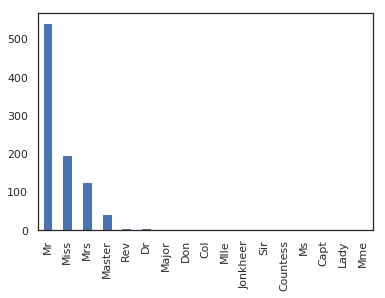

In [8]:
train.name.str.extract(' ([A-Za-z]+)\.', expand = False).value_counts().plot('bar')


Notice that the mayority of passengers is `Male`, followed by 'Womans' classified into `Miss` (probably young ladies) and `Mrs`. Then we have `Master` for male children. This suggests the creation of  a categorical feature with `Title` classes as follows:
* 0 : Mr
* 1 : Mrs
* 2: Miss
* 3: Master
* 4 : Other

In [0]:
#Define the auxiliary functions for this part of the processing

def title_label(string):
  if string == 'Mr':
    val = 0
  elif string == 'Mrs':
    val = 1
  elif string == 'Miss':
    val = 2
  elif string == 'Master':
    val = 3
  else:
    val = 4
  return val


def title_feats(df):
  
  # Extract the Title using regular expression patterns and save into a new column
  df['title'] = df.name.str.extract(' ([A-Za-z]+)\.', expand = False)
  # Create the title_label column
  df['title_label'] = df.title.apply(title_label)
  # Use this categorical feature to create one-hot encodings
  title_one_hot = pd.get_dummies(df.title_label)
  title_one_hot.columns = ['Mr', 'Mrs', 'Miss', 'Master', 'Other']
  df  = pd.concat([df, title_one_hot], axis = 1)
#   df = df.drop(['title_label'], axis =1)
  return df

Add the Title features to both train and test set. 

In [0]:
train_feat = title_feats(train)
test_feat = title_feats(test)

We want to see wether the Title classe have any relation with the target value. A bar chart serves the purpose of showing this given the binary nature of the target value. Here, we define auxiliary functions for plotting bar charts

In [0]:
def surv_bar(feat, df = train_feat, legend = None, stacked = True):
  '''
    A function that generates a bar plot by survival and the feature given as the input.
    feat: The feature that we  want to plot
    df: the dataframe
    legends: an array of strings for the legends of the plot
  '''
#   Create the temporary dataframes
  alive = df[df.survived == 1][feat].value_counts()
  dead = df[df.survived == 0][feat].value_counts()
  hist = pd.DataFrame([alive, dead])
  hist.index = ['alive', 'dead']
  legend = legend
  ttl_str = str(feat)
#   Generate the actual plot
  hist.plot(kind = 'bar', stacked = stacked, figsize = (8,6))
  plt.title('Survival Distribution by' + ' ' + ttl_str, fontsize = 15, fontweight = 'bold')
  if legend != None:
    plt.legend(legend)
  plt.xticks((0,1),('Alive', 'Dead'), rotation = 'horizontal', fontsize = 12)
  plt.ylabel('Count', fontsize = 14)


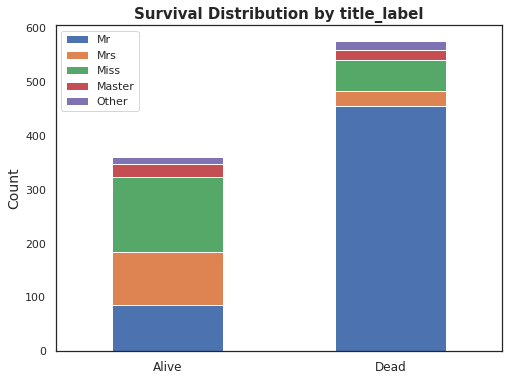

In [333]:
surv_bar('title_label', train_feat, legend = ['Mr', 'Mrs', 'Miss', 'Master', 'Other'] )

## Sex:

In [13]:
train.sex.unique()

array(['male', 'Female ', 'women', 'female_', 'male ', 'woman', ' male',
       'man', 'female', 'mal', nan, 'Male', ' female  '], dtype=object)

The above cell shows that are different ways the `sex` is encoded, we need to homogenize this feature, and then convert to one-hot encoding. The following function takes care of the homogenization. We keep `nan` values as they are (but as strings), we will deal with them after looking at the `Name` feature.

In [0]:
def sex_label(string):
  m_enc = ['male',  'male ', ' male', 'man',  'mal', 'Male' ]
  f_enc = ['Female ', 'women', 'female_','female',' female  ', 'woman']

  if string in m_enc:
    result = 'male'
  elif string in f_enc:
    result = 'female'
  else:
    result = 'nan'
  return result
    

In [0]:
# Apply the transformation
train_feat.sex = train_feat.sex.apply(sex_label)
test_feat.sex = test_feat.sex.apply(sex_label)
# train_feat.sex.unique()

In [0]:
# Define a function to handle the missing values
def fill_sex(string):
  
  male_ttl = ['Mr', 'Master', 'Don', 'Rev', 'Dr', 'Major', 'Sir', 'Col', 'Capt', 'Jonkheer']
  female_ttl = [ 'Mrs', 'Miss', 'Mme', 'Ms', 'Lady', 'Mlle', 'Countess']
  if string in male_ttl:
    res = 1 # male
  elif string in female_ttl:
    res = 0 # Female
  return res 

In [0]:
# We will use the Title feature to fill the nan values in the 'Sex' column
train_feat['sex'] = train_feat.title.apply(fill_sex)


In [252]:
# Use sklearn label encoder for the sex column in the test set
le = preprocessing.LabelEncoder()
le.fit(test_feat.sex)

LabelEncoder()

In [253]:
#  Check
le.transform(['male', 'female'])

array([1, 0])

In [0]:
test_feat.sex = le.transform(test_feat.sex)

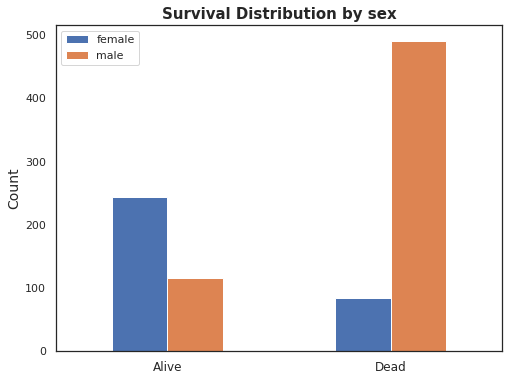

In [255]:
# Let's see the Survival distribution
surv_bar('sex', stacked = False, legend = ['female', 'male'])

Clearly there is a relation between the `sex` feature and the survival. The distribution is unbalanced suggesting that accuracy might not be the best way to evaluate the predictive models.

## Age:
There are some spurious values for this feature. Also, look at the values that are smaller than zero. NaN values will be dealt with later. 


In [256]:
print('Age:\nmax: {}\nmedian: {}\nmean: {}\nmin: {}'.format(train.age.max(),train.age.median(), train.age.mean(), train.age.min()))

Age:
max: 194.0
median: 28.0
mean: 29.77763368983957
min: 0.42


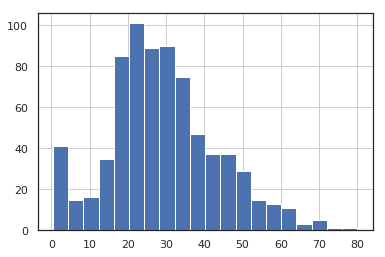

In [257]:
train_feat[train_feat.age < 100].age.hist(bins =20)

 We will replace the age values that are greater than 100 by the title median. However, since they are so few, we could look to external databases to fix the values. In particular [here](https://en.wikipedia.org/wiki/Passengers_of_the_RMS_Titanic) one can find the complete list of passengers. 

In [258]:
train_feat[train_feat.age > 100]

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,title,title_label,Mr,Mrs,Miss,Master,Other
33,34,0,2.0,"Wheadon, Mr. Edward H",1,117.0,0,0,C.A. 24579,10.50,NaN,S,Mr,0,1,0,0,0,0
152,153,0,3.0,"Meo, Mr. Alfonzo",1,194.0,0,0,A.5. 11206,8.05,NaN,S,Mr,0,1,0,0,0,0


In [0]:
train_feat.loc[train_feat.age > 100, 'age'] = train_feat.groupby('title').age.median()['Mr']

# Check
# train_feat[train_feat.age > 100]

We plot an estimate of the probabilty distribution based on the age of the passengers. This, to see the age intervals with changes in probability, this can give us an idea of how to construct a bucketized feature out of `age`. 

To that intent, we define a plotting function that will useful later as well.

In [0]:
# Define an auxiliar function to plot the prob distribution -a kde- for a given feat
def plot_dist(feat, df = train_feat, h = 'survived', zoom = False, x0=0, xm =100):
#   print('i work')
  facet = sns.FacetGrid(df, hue=h, aspect=4)
  facet.map(sns.kdeplot,feat,shade= True)
  facet.set(xlim=(0, df[feat].max()))
  facet.add_legend()
  if zoom == True:
    plt.xlim(x0,xm)
  plt.show()

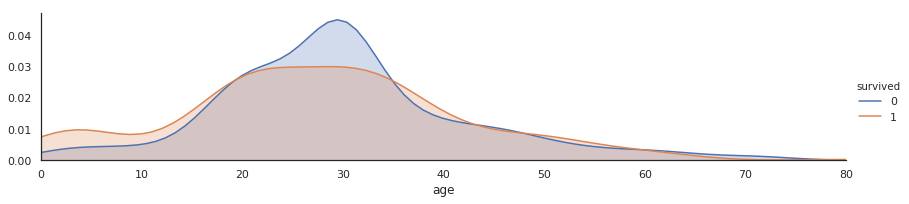

In [78]:
plot_dist('age')

It seems that from 0 to ~17 there is greater probability of surviving, this can be our first age bin. Let us have a closer look.

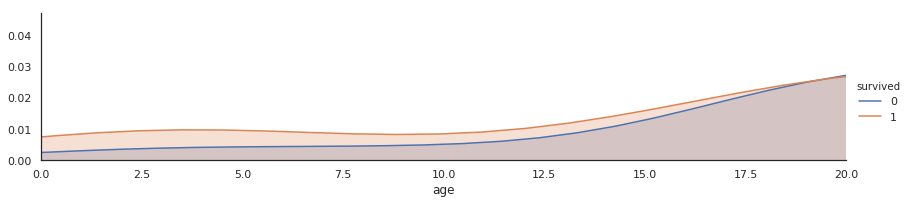

In [80]:
plot_dist('age', zoom = True, x0=0, xm =20)

The next change in prob behaviour seems to happen between `age=16`  and `age=26` where there is a slight increase of the prob of not surviving. This is no surprise for two reasons:
* Most of the passenger tripulation is male.
* Most of males have ages around [20,30] years.

In [0]:
# Define helper variables for the plots

dead_men = train_feat[(train_feat.survived == 0) & (train_feat.sex == 1)].age.value_counts(bins=15, sort= False)
alive_men = train_feat[(train_feat.survived ==1) & (train_feat.sex == 1)].age.value_counts(bins=15, sort= False)
dead_women = train_feat[(train_feat.survived == 0) & (train_feat.sex == 0)].age.value_counts(bins=15, sort= False)
alive_women = train_feat[(train_feat.survived == 1) & (train_feat.sex == 0)].age.value_counts(bins=15, sort= False)
men = train_feat[train_feat.sex == 1].age.value_counts(bins=15, sort= False)
women = train_feat[train_feat.sex == 0].age.value_counts(bins=15, sort= False)

In [0]:
def sex_dist(size= (8,6), s_men = men, s_women = women, index = men.index, ttl_suffix = '' ):
  plt.figure(figsize=size) 
  width=0.35
  x =  [i for i in range(len(index))]
  x = np.array(x)
  plt.bar(x = x, height = s_men, width=width, align = 'center', label = 'male')
  plt.bar(x = x + width, height = s_women, width=width, align = 'center', label = 'female')
  plt.xlabel('Age bin', fontdict={'size': 13} )
  plt.xticks(np.arange(15), ('5', '9', '13', '17', '21', '25', '30', '33', '38', '42', '46', '50', '55', '58', '64'))
  plt.ylabel('Count', fontdict={'size':13})
  plt.title('Age and Sex distribution' + ' ' + ttl_suffix, fontdict={'size': 20, 'weight': 'bold'})
  plt.grid(True, axis='y')
  plt.legend(prop={'size': 15})

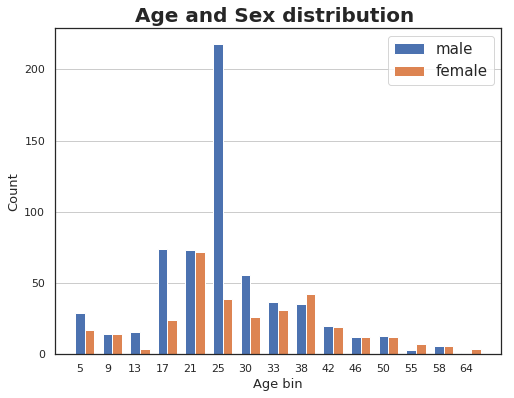

In [159]:
sex_dist()

The age distribution of passengers by sex shows that indeed most of passengers are males and most of males have ages within [20,30]

Age distribution of surviving passengers by *sex*

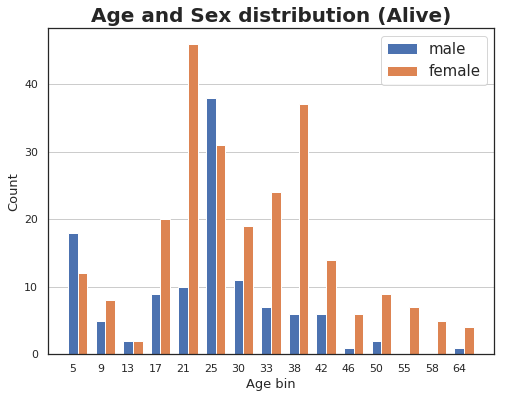

In [152]:
sex_dist(s_men = alive_men, s_women = alive_women, ttl_suffix= '(Alive)')

Age distribution of not - surviving passengers by *sex*

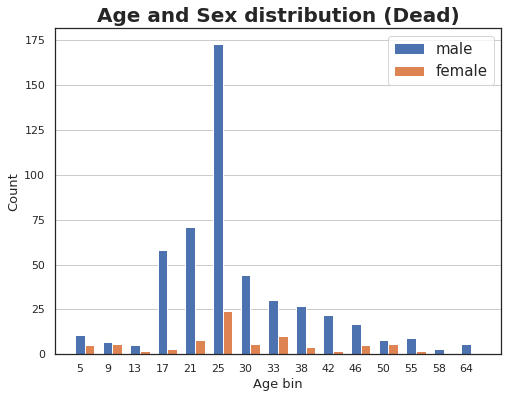

In [154]:
sex_dist(s_men = dead_men, s_women = dead_women, ttl_suffix= '(Dead)')

The next change in survival prob behavior is signaled by an increase of the prob of not surviving. We have another bin

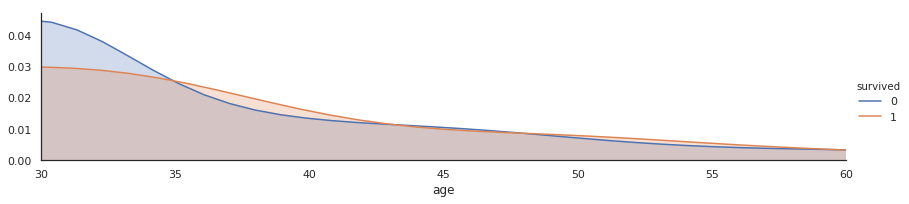

In [163]:
plot_dist('age', zoom = True, x0 = 30, xm = 60)

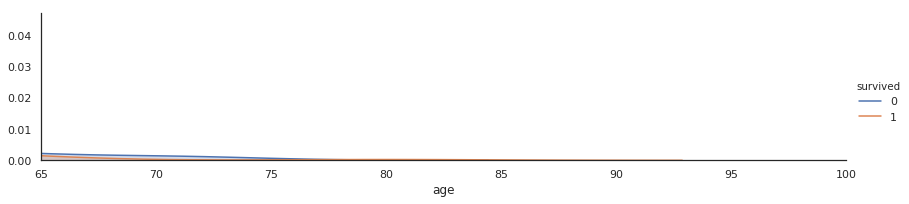

In [164]:
plot_dist('age', zoom = True, x0 = 65, xm = 100)

There are passengers with ages smaller than 1 year. Looking at the `name` column is clear that they are indeed childs. 

Age has missing values and we will use the  median of each 'title' to fill them Moreover, we will create a label encoding for the age ranges of passengers, based on:

* 0 : Child [0, 16]
* 1 : Young [16, 26]
* 2 : Adult [26, 36]
* 3 : Mid-age [36, 64]
* 4 : Senior [64, 100]


In [0]:
train_feat['age'].fillna(train_feat.groupby('title').age.transform('median'),inplace = True)
test_feat['age'].fillna(train_feat.groupby('title').age.transform('median'),inplace = True)

In [0]:
# Encode the age of passengers according the scheme we defined above

def age_label(age):
  
#   Create the filters:
  if age <= 14:
    label = 0
  elif age > 15 and age <=26:
    label = 1
  elif age > 26 and age <= 36:
    label = 2
  elif age > 36 and age <= 64:
    label = 3
  else:
    label = 4
  return label
  

In [0]:
train_feat['age_l'] = train_feat.age.apply(age_label)
test_feat['age_l'] = test_feat.age.apply(age_label)
# train_feat.head()
# test_feat.head()


## Family Size

Now we will look at the family related features. Family size could be an important feature so we will construct it and investigate its relation with the survival of passengers. There are two columns `['sibsp', 'parch']`. They stand for *Siblings and Spouse* and *Parents and Children*

### Siblings and Spouse

In [168]:
train.sibsp.unique()

array([1, 0, 3, 4, 2, 5, 8])

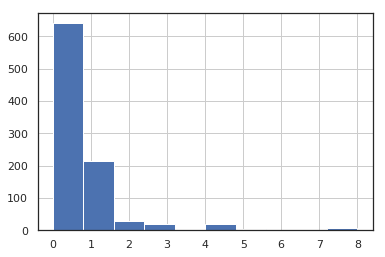

In [169]:
train.sibsp.hist()

In [170]:
train[train.sibsp == 0].shape

(641, 14)

From the above cell we can say that most of the passengers were traveling alone. This could be made into a new feature: `IsAlone`. 

### Parents and children:


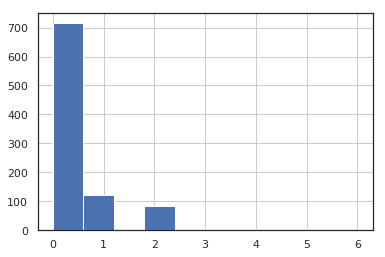

In [171]:
train.parch.hist()

In [172]:
train[train.parch == 0].shape

(715, 14)

Again, most of the passengers seem to have been traveling by themselves. So, we create two new features, namely, `['alone', 'family_size']`

In [0]:
# Create the family size feature
train_feat['family_size'] = train_feat.sibsp + train_feat.parch + 1
test_feat['family_size'] = test_feat.sibsp + test_feat.parch + 1

In [0]:
# A function to create the alone feature
def get_alone(size):
  
  if size == 1:
    return 1
  else:
    return 0

In [0]:
# Create the actual 'alone' feature both in train and test

train_feat['alone'] = train_feat.family_size.apply(get_alone)
test_feat['alone'] = test_feat.family_size.apply(get_alone)

## Pclass:
This feature accounts for the class each passenger was staying at, during the trip. There are some missing values for his columns, and filling them is not obvious. For this reason, we will leave the task to a classification algorithm. In particular, we will use  Gradient Boosted Decision Trees. They will be trained on the part of data for which we have the `pclass` feature. Then we predict the `pclass` of the missing rows.

In [0]:
#  Define the features to be used by the classification model
features_k = ['survived', 'sex', 'age', 'sibsp',
       'parch', 'fare', 'title_label',
       'Mr', 'Mrs', 'Miss', 'Master', 'Other', 'age_l', 'family_size',
       'alone']

# Create train/validation split
kX_train, kX_valid, ky_train, ky_valid = train_test_split(train_feat[~train_feat.pclass.isna()][features_k], train_feat[~train_feat.pclass.isna()]['pclass'], test_size=0.2, random_state=42)


In [267]:
pclass_model = XGBClassifier(learning_rate = 0.05, n_estimators=300, max_depth=5)
pclass_model.fit(kX_train, ky_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [268]:
# make predictions in the validation set
y_pred = pclass_model.predict(kX_valid)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(ky_valid, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
target_names = ['1st class', '2nd class', ' 3rd class']
print('Classification Report:\n'+'-'*53)
print(classification_report(ky_valid, predictions, target_names=target_names))

Accuracy: 96.24%
Classification Report:
-----------------------------------------------------
              precision    recall  f1-score   support

   1st class       0.98      0.96      0.97        47
   2nd class       0.91      0.91      0.91        35
   3rd class       0.97      0.98      0.98       104

    accuracy                           0.96       186
   macro avg       0.95      0.95      0.95       186
weighted avg       0.96      0.96      0.96       186



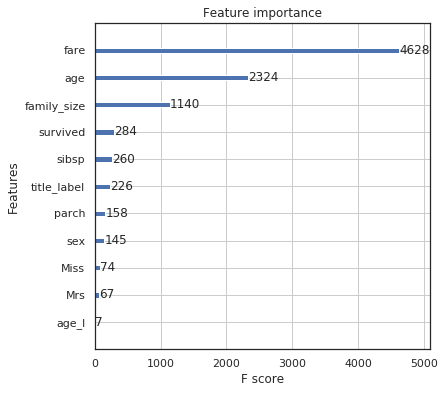

In [269]:
# Plot the feature importance of the model

plot_features(pclass_model, (6,6))

In [0]:
# Predict and fill missing values
class_predict = pclass_model.predict(train_feat[train_feat.pclass.isna()][features_k])
train_feat.loc[train_feat.pclass.isna(), 'pclass']  = class_predict

In [271]:
train_feat.isna().sum()

passengerid      0
survived         0
pclass           0
name             0
sex              0
age              0
sibsp            0
parch            0
ticket           0
fare             0
cabin          726
embarked         2
title            0
title_label      0
Mr               0
Mrs              0
Miss             0
Master           0
Other            0
age_l            0
family_size      0
alone            0
dtype: int64

As expected, the class is related to the survival of passengers. The greatest part of dead passengers were from `3rd class`.

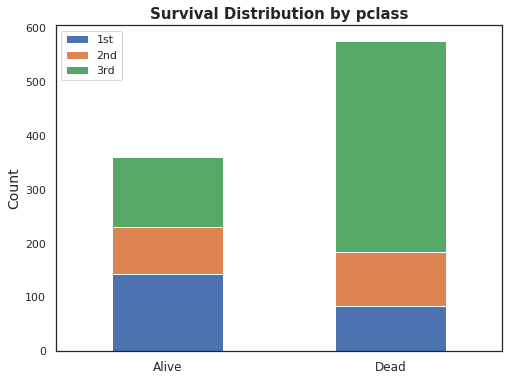

In [272]:
surv_bar('pclass', legend=['1st', '2nd', '3rd'])

## Embarked

This feature has a couple of missing values. We will use a sort of 'majority vote' to fill these values.

In [273]:
print('Missing values: {}'.format(train_feat.embarked.isna().sum()))

Missing values: 2


In [274]:
train_feat[train_feat.embarked.isna()]

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,title,title_label,Mr,Mrs,Miss,Master,Other,age_l,family_size,alone
61,62,1,1.0,"Icard, Miss. Amelie",0,38.0,0,0,113572,80.0,B28,NaN,Miss,2,0,0,1,0,0,3,1,1
829,830,1,1.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,62.0,0,0,113572,80.0,B28,NaN,Mrs,1,0,1,0,0,0,3,1,1


In [275]:
# Check unique values
train_feat.embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

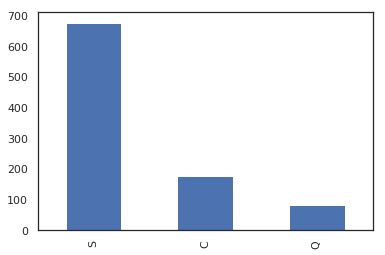

In [276]:
# check the distribution of unique values
train_feat.embarked.value_counts().plot('bar')


We decided to fill missing values with 'S'  for embarked

In [0]:
train_feat.embarked.fillna('S', inplace = True)

In [0]:
train_feat = pd.concat([train_feat, pd.get_dummies(train_feat.embarked)], axis =1)
test_feat = pd.concat([test_feat, pd.get_dummies(test_feat.embarked)], axis =1)
#   df  = pd.concat([df, title_one_hot], axis = 1)


## Fare:
Now, we explore the `fare` feature, which as we saw is related to the class and certainly with the chance of surviving.
Start by checking for missing values.

In [279]:
print('Missing values\ntrain: {}\ntest: {}'.format(train_feat.fare.isna().sum(), test_feat.fare.isna().sum()))

Missing values
train: 0
test: 1


In [0]:
# Fill missing values with the median fare per class:
test_feat.fare.fillna(train_feat.groupby('pclass').fare.transform('median'), inplace = True)

In [281]:
print('Missing values\ntrain: {}\ntest: {}'.format(train_feat.fare.isna().sum(), test_feat.fare.isna().sum()))

Missing values
train: 0
test: 0


We will encode the fare as a categorical feature. To define the buckets we look at the survival distribution 


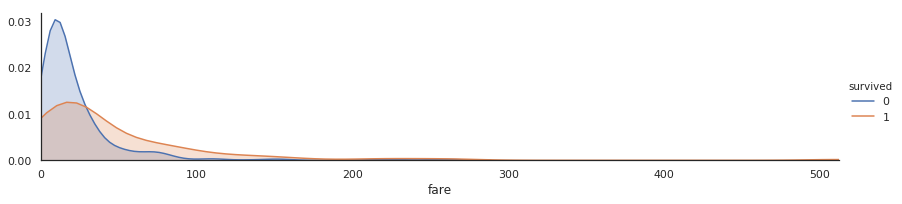

In [282]:
plot_dist('fare')

Let us have a closer look

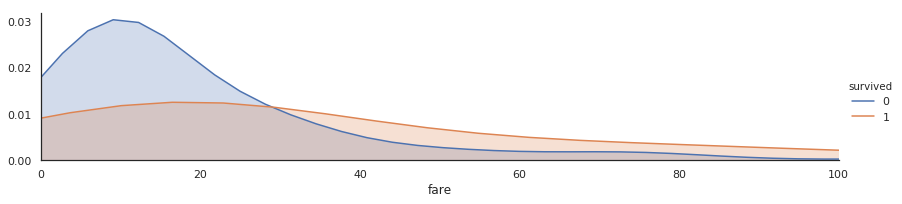

In [283]:
plot_dist('fare', zoom = True, x0=0, xm=100)

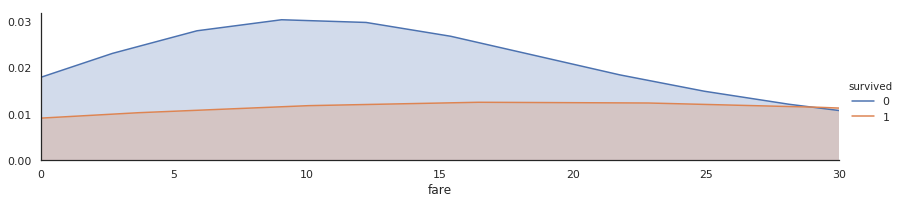

In [284]:
plot_dist('fare', zoom = True, x0=0, xm=30)

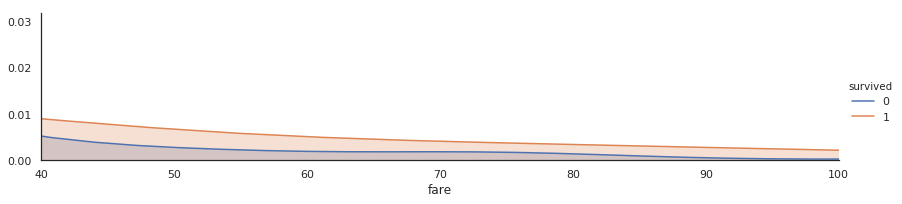

In [285]:
plot_dist('fare', zoom = True, x0=40, xm=100)

In [0]:
def fare_bucket(fare):
  
  # returns buckets for the fare
  if fare <= 29:
    res = 0
  elif fare > 29 and fare <= 75:
    res = 1
  else:
    res = 2
  return res

In [0]:
train_feat['fare_b'] = train_feat.fare.apply(fare_bucket)
test_feat['fare_b'] = test_feat.fare.apply(fare_bucket)

In [329]:
train_feat[train_feat.survived == 1]['fare_b'].value_counts()

0    212
2     75
1     73
Name: fare_b, dtype: int64

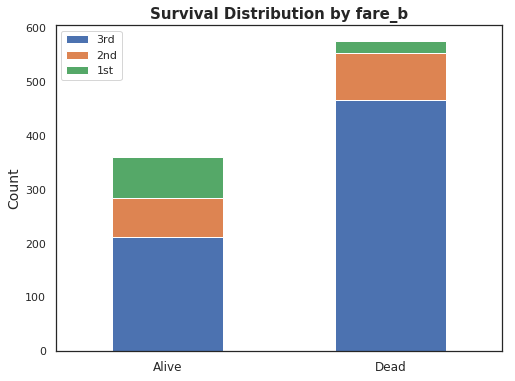

In [336]:
surv_bar('fare_b', train_feat, legend=['3rd', '2nd', '1st'])

## Cabin:
This feature in particular has a lot of missing values. In fact, the lack of values for almost 70% of the dataset can itslef be used as data.

In [289]:
print('Missing values: {}'.format(train_feat.cabin.isna().sum()))

Missing values: 726


In [290]:
train_feat.cabin.value_counts().head()


C23 C25 C27    4
B96 B98        4
G6             4
F33            3
F2             3
Name: cabin, dtype: int64

Let's extract the cabin prefix, it may be related to the class and thus could be a good feature to have.


In [0]:
train_feat['cabin'] = train_feat.cabin.str[:1]

In [292]:
train_feat.cabin.value_counts()

C    61
B    47
D    36
E    32
A    16
F    13
G     4
T     1
Name: cabin, dtype: int64

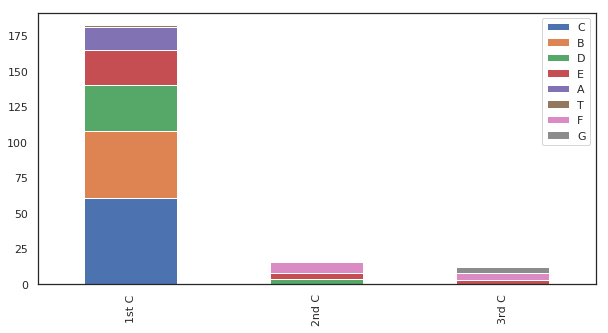

In [293]:
C1 = train_feat[train_feat['pclass']==1]['cabin'].value_counts()
C2 = train_feat[train_feat['pclass']==2]['cabin'].value_counts()
C3 = train_feat[train_feat['pclass']==3]['cabin'].value_counts()
df = pd.DataFrame([C1, C2, C3])
df.index = ['1st C','2nd C', '3rd C']
df.plot(kind='bar',stacked=True, figsize=(10,5))

We will encode the cabin as a numeric feature, we want to mantain the order relation between the different values. 

In [0]:
cabin_map = {"A": 0, "B": 0.4, "C": 0.8, "D": 1.2, "E": 1.6, "F": 2, "G": 2.4, "T": 2.8}
train_feat['cabin'] = train_feat.cabin.map(cabin_map)   
test_feat['cabin'] = test_feat.cabin.map(cabin_map)   

In [0]:
# Now we can fill the missing values using the median for each class.
train_feat.cabin.fillna(train_feat.groupby('pclass').cabin.transform("median"), inplace=True)
test_feat.cabin.fillna(train_feat.groupby('pclass').cabin.transform("median"), inplace=True)



# Modeling 
---

The problem is stated as a classification problem. We are asked to predict whether a certain passenger (given the data)  will survive a naval accident. This in order to make decisions about the insurance policy charged in the ticket, for instance.


In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


## Cross-Validation K-Folds

We will use cross validation with k-folds to test the performance of our predictive models.

In [0]:

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)


In [0]:
# select the actual columns that go as the train data
cols = [ 'pclass', 
        'sex', 
        'age', 
        'fare', 
        'cabin', 
        'Mr', 'Mrs', 'Miss', 'Master', 'Other', 
        'age_l', 
        'family_size', 
        'alone',
       'fare_b', 
        'C', 'Q', 'S']


In [299]:
knn = KNeighborsClassifier(n_neighbors = 12)
scoring = 'accuracy'
score = cross_val_score(knn, train_feat[cols], train_feat['survived'], cv=k_fold, n_jobs=1, scoring=scoring)
print(score)


[0.76595745 0.75531915 0.72340426 0.62765957 0.63829787 0.74468085
 0.77419355 0.74193548 0.74193548 0.76344086]


In [300]:
# kNN Score
round(np.mean(score)*100, 2)

72.77

## Random Forest

In [301]:
rf_clf = RandomForestClassifier(n_estimators=13)
scoring = 'accuracy'
score = cross_val_score(rf_clf, train_feat[cols], train['survived'], cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.82978723 0.75531915 0.78723404 0.78723404 0.79787234 0.87234043
 0.77419355 0.82795699 0.8172043  0.8172043 ]


In [302]:
# Random Forest Score
round(np.mean(score)*100, 2)

80.66

## XGBoost (Gradient Boosting):


In [343]:
xgb_clf = XGBClassifier(learning_rate = 0.05, n_estimators=500, max_depth=10)
scoring = 'accuracy'
score = cross_val_score(xgb_clf, train_feat[cols], train_feat['survived'], cv=k_fold, n_jobs=1, scoring=scoring)
print(score)
# xgb_clf.fit(kX_train, ky_train)

[0.87234043 0.82978723 0.77659574 0.79787234 0.80851064 0.89361702
 0.83870968 0.84946237 0.78494624 0.84946237]


In [344]:
# XGBoost Score
round(np.mean(score)*100, 2)

83.01

## Naive Bayes

In [303]:
nb_clf = GaussianNB()
scoring = 'accuracy'
score = cross_val_score(nb_clf, train_feat[cols], train_feat['survived'], cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.84042553 0.70212766 0.78723404 0.75531915 0.73404255 0.79787234
 0.78494624 0.79569892 0.77419355 0.79569892]


In [304]:
# Naive Bayes Score
round(np.mean(score)*100, 2)


77.68

## Support Vector Machine

In [305]:
svc = SVC()
scoring = 'accuracy'
score = cross_val_score(svc, train_feat[cols], train_feat['survived'], cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default 

[0.81914894 0.76595745 0.73404255 0.68085106 0.72340426 0.78723404
 0.78494624 0.79569892 0.74193548 0.78494624]


In [306]:
## SVM Classifier score
round(np.mean(score)*100,2)

76.18

## Dense Neural Network Classifier

In [227]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [0]:
# Create a simple dense neural network classifier:
def dnn_cls(n_cols = train_feat[cols].shape[1]):
  # clear session
  K.clear_session()
  
  # sequential model
  dnn = Sequential()

  # add dense layers
  dnn.add(Dense(10, activation='relu', input_shape=(n_cols,)))
  dnn.add(Dense(20, activation='relu'))
  dnn.add(Dense(10, activation='relu'))
  dnn.add(Dense(1, activation = 'sigmoid'))
  
  # compile model w/ binary cross entropy as a measure of model performance
  dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  
  #give the summary
#   dnn.summary()
  return dnn

# Define a function to train the model:
def train_dnn(patience= 5, cols = cols, epochs = 30, valid_split = 0.2 ):
  #set early stopping monitor so the model stops training when it won't improve anymore
  early_stopping_monitor = EarlyStopping(patience=5)

  #train model
  results = dnn.fit(train_feat[cols], train_feat['survived'], validation_split= valid_split, epochs = epochs, callbacks=[early_stopping_monitor])
  return results

In [0]:
dnn = dnn_cls()

In [309]:
results = train_dnn(epochs = 100)

Train on 748 samples, validate on 188 samples
Epoch 1/100
748/748 [==============================] - 0s 471us/step - loss: 1.1070 - acc: 0.6725 - val_loss: 0.6242 - val_acc: 0.6968
Epoch 2/100
748/748 [==============================] - 0s 61us/step - loss: 0.6989 - acc: 0.6671 - val_loss: 0.5550 - val_acc: 0.6755
Epoch 3/100
748/748 [==============================] - 0s 59us/step - loss: 0.6299 - acc: 0.6217 - val_loss: 0.5541 - val_acc: 0.6702
Epoch 4/100
748/748 [==============================] - 0s 56us/step - loss: 0.6115 - acc: 0.6243 - val_loss: 0.5530 - val_acc: 0.6436
Epoch 5/100
748/748 [==============================] - 0s 55us/step - loss: 0.6020 - acc: 0.6190 - val_loss: 0.5531 - val_acc: 0.6277
Epoch 6/100
748/748 [==============================] - 0s 53us/step - loss: 0.5955 - acc: 0.6283 - val_loss: 0.5489 - val_acc: 0.6809
Epoch 7/100
748/748 [==============================] - 0s 54us/step - loss: 0.5827 - acc: 0.6257 - val_loss: 0.5498 - val_acc: 0.6702
Epoch 8/100
748

In [0]:
def plot_results():
  plt.figure(figsize = (6,6))
  plt.title("Learning curve", fontsize = 15)
  plt.plot(results.history["acc"], label="accuracy")
  plt.plot(results.history["val_acc"], label="val accuracy")
  plt.plot( np.argmax(results.history["val_acc"]), np.max(results.history["val_acc"]), marker="x", color="r", label="best model")
  plt.xlabel("Epochs")
  plt.ylabel("accuracy")
  plt.legend();


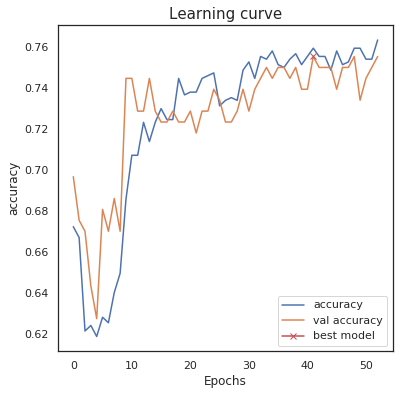

In [311]:
plot_results()

In [0]:
dnn_model = KerasClassifier(build_fn=dnn_cls, verbose=0)

In [313]:
scoring = 'accuracy'
score = cross_val_score(dnn_model, train_feat[cols], train_feat['survived'], cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.72340426 0.26595745 0.63829787 0.61702128 0.68085106 0.61702128
 0.34408602 0.64516129 0.65591398 0.68817204]


In [314]:
# DNN score
round(np.mean(score)*100,2)

58.76

# Predicting
---
we will use our two top rated models to make predictions

In [0]:
# Random Forest

rf_clf = RandomForestClassifier(n_estimators=13)
scoring = 'accuracy'
# score = cross_val_score(rf_clf, train_feat[cols], train['survived'], cv=k_fold, n_jobs=1, scoring=scoring)
# print(score)
rf_clf.fit(train_feat[cols], train_feat['survived'])
prediction = rf_clf.predict(test_feat[cols])

In [0]:
prediction = pd.DataFrame({
        "PassengerId": test_feat["passengerid"],
        "Survived": prediction
    })

prediction.to_csv('submission.csv', index=False)


In [356]:
prediction.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [0]:
# Gradient Boosting
xgb_clf = XGBClassifier(learning_rate = 0.05, n_estimators=500, max_depth=10)
scoring = 'accuracy'
xgb_clf.fit(train_feat[cols], train_feat['survived'])
prediction_xgb = xgb_clf.predict(test_feat[cols])

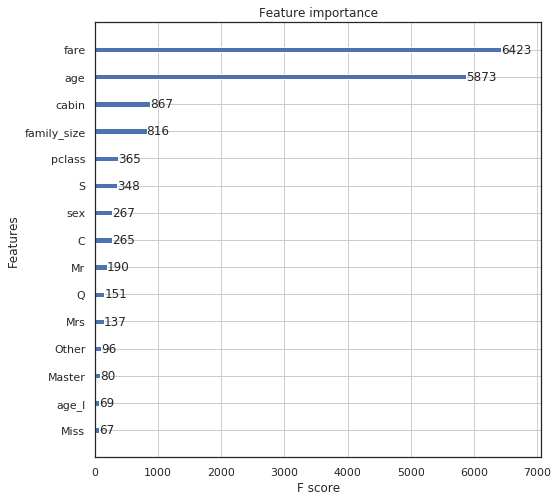

In [359]:
plot_features(xgb_clf, (8,8))

In [0]:
prediction_xgb = pd.DataFrame({
        "PassengerId": test_feat["passengerid"],
        "Survived": prediction_xgb
    })

prediction_xgb.to_csv('submission_xgb.csv', index=False)


In [352]:
prediction_xgb.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1


# Final Remarks
---
An understanding of the key features that have impact on survival probability of passengers is achieved through Data exploration. We have identified some of the key features and also constructed new features that would help improve the accuracy of predicitive models. The Gradient Boosting algorithm sort of shows a ranking of feature importance based on the **F-score**. Showing that:


1.   `Fare`
2.   `age`
3.   `cabin`
4.   `family_size`
5.   `pclass`

are the top 5 important features. Already some insights and decisions can be taken at this point. For instance, charging an extra insurance fee to the passengers with higher risk may not be the best way to go, considering that these passengers buy the cheapest tickets. Avoiding them to travel by rising all tickets price could lead to lowring the chances if the extra earnings are correctly invested in the safety of ships in the **fleet*.

### Further Development.-

The predictive power of the models has to be improved This stage is a bit time consuming since it passes through running all the models several times. Random Forests and XGBoost outperform the other models and that is why we choose them to in this notebook. Nevertheless, the models need to go through a hyperparameter tunning process. This, to find the best model for the given Data. This could make the DNN Classifier perform better than the other two. Finally, the models need to go through a statistical significance test to select the model that goes to production.